In [2]:
import numpy as np 
import matplotlib.pyplot as plt



/Users/lucasspencer/opt/anaconda3/envs/plaidml/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


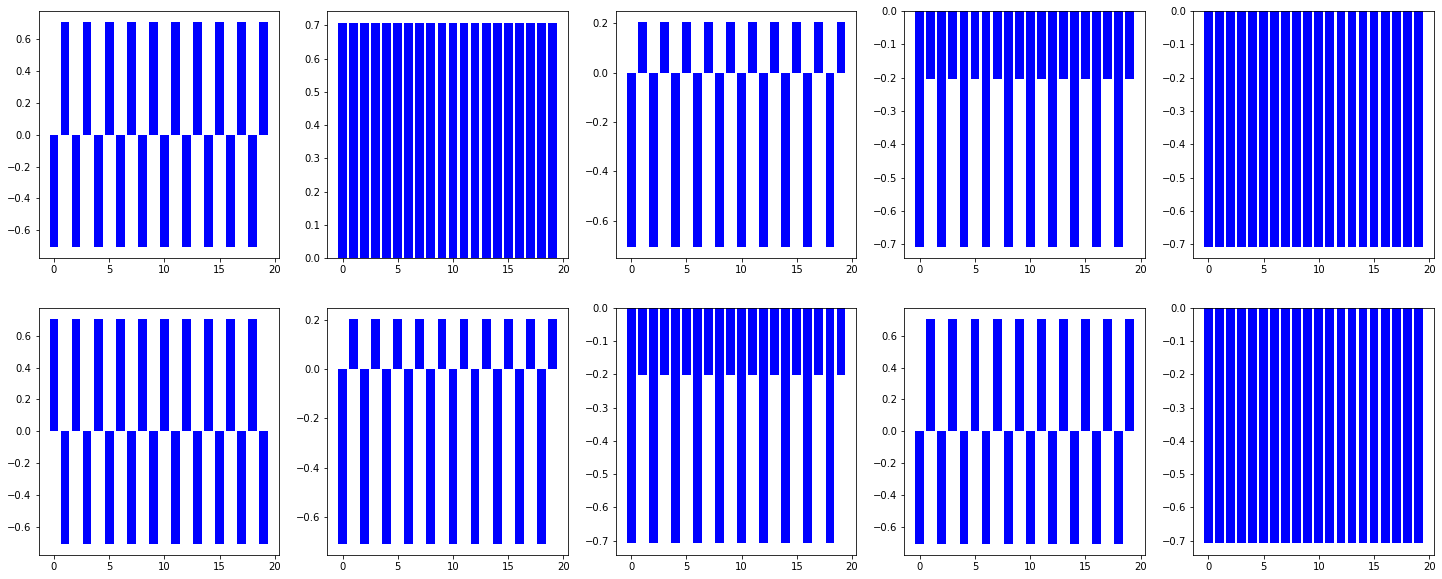

In [594]:
def is_even(n):
    return n//2 * 2 == n

# define the SSH hamiltonian
def ssh_finite(v,w, N):
    # need N to be even
    if not is_even(N):
        raise Exception("N must be even")

    # Create the matrix
    mat = np.zeros((N, N))
    
    for k in range(0,N//2):
        i = 2 * k
        mat[i][i+1] = v
        mat[i+1][i] = v
        if i + 2 < N:
            mat[i+1][i+2] = w
            mat[i+2][i+1] = w
    
    # Compute eigenvectors
    eigs, vecs = np.linalg.eigh(mat)
    return eigs, vecs.T

def ssh_bulk(v, w, N):
    # Compute the spacings for the wave number
    k_range = np.linspace(0,2 *np.pi, N//2)

    # Compute the eigenvalues and eigenvectors for a specific wave numebr
    def k_eigs(k):
        mat = np.array([
            [0, v + w * np.exp(-1j*k)],
            [v + w * np.exp(1j*k),0]
        ])

        return np.linalg.eigh(mat)

    # Compute all eigenvalues and vectors
    eigs = []
    evecs = []
    for k in k_range:
        eig, vecs = k_eigs(k)

        eigs += list(eig)
        evecs += list(vecs.T)

    return np.array(eigs), np.array(evecs)

# Eigenvector plotting
# splits into +ve negative eigenvectors
def plot_eigs(eigs):
    p_eigs = np.sort(eigs[eigs>0])
    n_eigs = np.sort(eigs[eigs<0])[::-1]

    plt.plot(p_eigs)
    plt.plot(n_eigs)

# Plots an eigenvector
def plot_eigvec(vec, y_scale=0.5):
    plt.ylim(-y_scale, y_scale)
    plt.bar(list(range(0,len(vec))),vec)

def plot_periodic_eigvec(vec, N=10):
    l = len(vec)
    for i in range(0, N):
        plt.bar(list(range(i * l, (i+1) * l)), vec, color='blue')

plt.figure(figsize=(25,10))
for i in range(0,10):
    plt.subplot(2,5,i + 1)      
    plot_periodic_eigvec(ssh_bulk(0.3,1,10)[1][i])

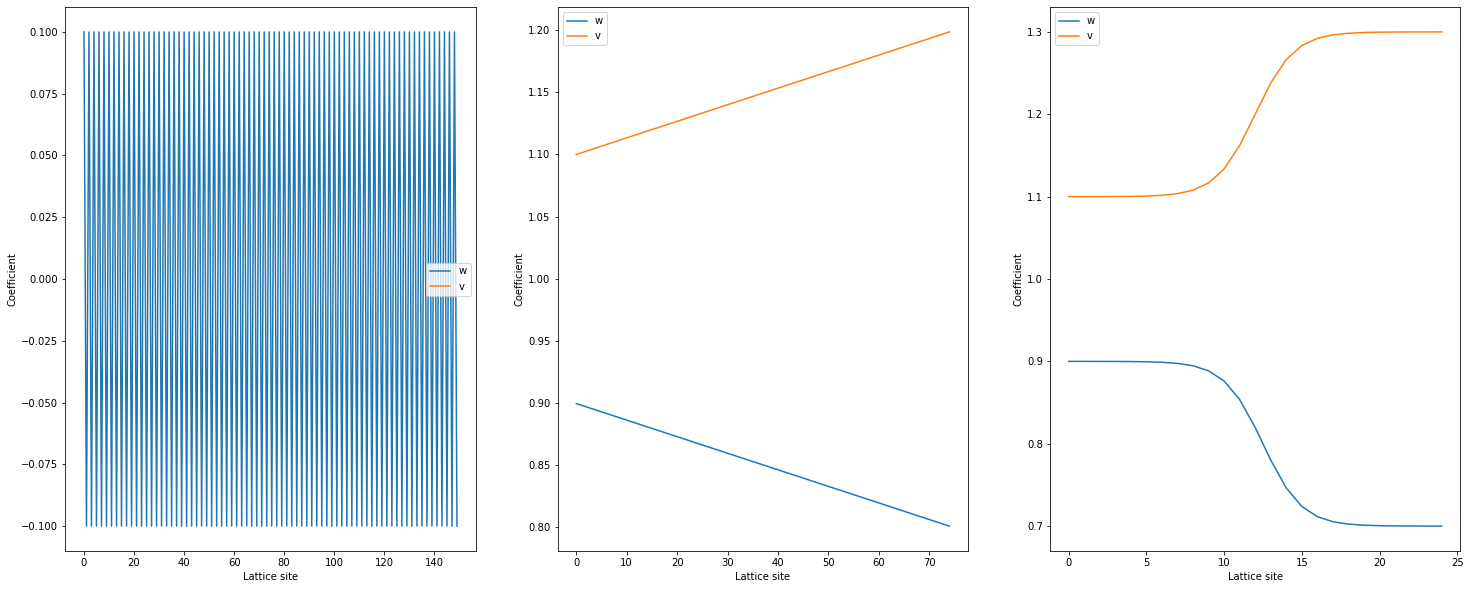

In [932]:
# Define the toy model hamiltonian

def toy_finite(v, N, epsilon):
    # need N to be even
    if not is_even(N):
        raise Exception("N must be even")

    mat = np.zeros((N,N))
    for k in range(0,N//2):
        i = 2 * k
        mat[i][i+1] = v(i, epsilon)
        mat[i+1][i] = v(i, epsilon)
        if i + 2 < N:
            mat[i+1][i+2] = v(i+1, epsilon)
            mat[i+2][i+1] = v(i+1, epsilon)
    
     # Compute eigenvectors
    eigs, vecs = np.linalg.eigh(mat)
    return eigs, vecs.T

def linear_perturbation(N, start=0, end=1, base_size=0.1):
    def v(i, epsilon):
        return 1 + (-1)**i * (epsilon * i * (end - start)/ N + base_size)

    return v

def tanh_perturbation(N, rate=10, base_size=0.1):
    def v(i, epsilon):
        if is_even(i):
            return 1 - epsilon * (np.tanh((i - N//2) * rate / N) + 1) - base_size
        return 1 + epsilon * (np.tanh((i - N//2) * rate / N) + 1) + base_size
    
    return v

def uniform_perturbation(base, base_size=0):
    def v(i, epsilon):
        return base + (-1)**i * (epsilon + base_size)
    
    return v

def plot_pert(perturbation, N, epsilon=0.1):
    r = list(range(0,N//2))
    perts = []

    for i in range(0,N):
        perts.append(perturbation(i, epsilon))
    
    perts = np.array(perts)
    ws = perts[perts<=1]
    vs = perts[perts>1]

    plt.xlabel("Lattice site")
    plt.ylabel("Coefficient")

    plt.plot(list(range(0,len(ws))), ws, label='w')
    plt.plot(list(range(0,len(vs))), vs, label='v')
    plt.legend()

plt.figure(figsize=(25,10))
plt.subplot(131)
plot_pert(uniform_perturbation(0),150)
plt.subplot(132)
plot_pert(linear_perturbation(150),150)
plt.subplot(133)
plot_pert(tanh_perturbation(50),50)

# plot_eigs(toy_finite(tanh_perturbation(100),100)[0])
# plot_eigs(ssh_finite(1.0,1.0,100)[0])


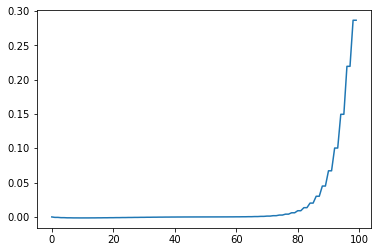

In [945]:
# Now introduce time dependent polarization computations, this involves slowly turning on the perturbation (epsilon 0 -> e)
# We can use the previously defined toy model to compute the instantaneous eigenvectors/values

def toy_finite_hamiltonian(perturbation, N):
    def H(epsilon):
        return toy_finite(perturbation, N, epsilon)
    
    return H

# Compute the right charge operator expectation
def right_charge(a, v):
    # Formally Q is a matrix of size N * N with 1's on the diagonal for indicies i >= a else 0
    # So its the following inner product
    return np.vdot(v[a:], v[a:])

# Compute the current contribution from each eigenvector at each timestep
def single_eig_current(H, N, min_e = 0, max_e = 0.9, timesteps=100):
    # Compute all eigenvectors for each step 
    vecs = []
    eigs = []
    epsilon_step = (max_e - min_e)/timesteps
    for t in range(0, timesteps):
        t_eigs, t_vecs = H(t * epsilon_step)

        vecs.append(t_vecs)
        eigs.append(t_eigs)
    
    vecs = np.array(vecs)
    eigs = np.array(eigs)

    # Now compute the gradients of the vecs across the timesteps
    vec_grads = np.gradient(vecs)[0]

    currents = np.zeros((N, timesteps, N))

    for a in range(0, N):
        for t in range(0, timesteps):
            vec_grads_t = vec_grads[t]
            vecs_t = vecs[t]
            for n in range(0, N):
                # This neglects the rate parameter d_t lambda which cancels in the final integral
                currents[a,t,n] = -right_charge(a, vecs_t[n], vec_grads_t[n]) - right_charge(a, vec_grads_t[n], vecs_t[n])
                
    return currents

# Compute the explicit polarization induced by the occupied states
def local_polarization(H, N, min_e=0, max_e=0.1, states=None):
    # compute the eigenstates of the system at the start and end of the perturbative change
    # here we only consider perturbations which do not close the band gap
    s_eigs, s_vecs = H(min_e)
    e_eigs, e_vecs = H(max_e)

    # If states==None we assume that the model has two energy bands and only the negative one is occupied
    # If both bands are occupied then the total polarization will cancel
    if states == None:
        states = np.arange(0,N)[e_eigs < 0]
    
    # Compute the contribution from each eigenstate
    polarizations = np.zeros(N)

    for a in range(0,N):
        for n in states:
            polarizations[a] += right_charge(a, s_vecs[n]) - right_charge(a, e_vecs[n])

    return polarizations

# Code berry phase polarization tomorrow, see if the issue is still present then and if it is then we know that we are understanding it wrong
# If there is no issue then we have something incorrect about our assumptions in computing the local polarization and need to approach it differently (not ideal)
plt.plot(np.arange(0,N), local_polarization(H, N, max_e=0.9))

In [934]:
N=100
H = toy_finite_hamiltonian(tanh_perturbation(N), N)

e, v = H(0)
print(right_charge(5,v[25]))
print(right_charge(5,v[100-26]))

def plot_perturbed_eigenvectors(H, epsilon, row_num=2, col_num=3):
    eigs, vecs = H(epsilon)
    plt.figure(figsize=(25,25))
    j=1
    for i in [25,26,27,100-26,100-27,100-28]:
        plt.subplot(row_num,col_num,j)
        j+=1
        plot_eigvec(vecs[i])
        plt.xlabel(eigs[i])

0.9508712028998263
0.9508712028998254


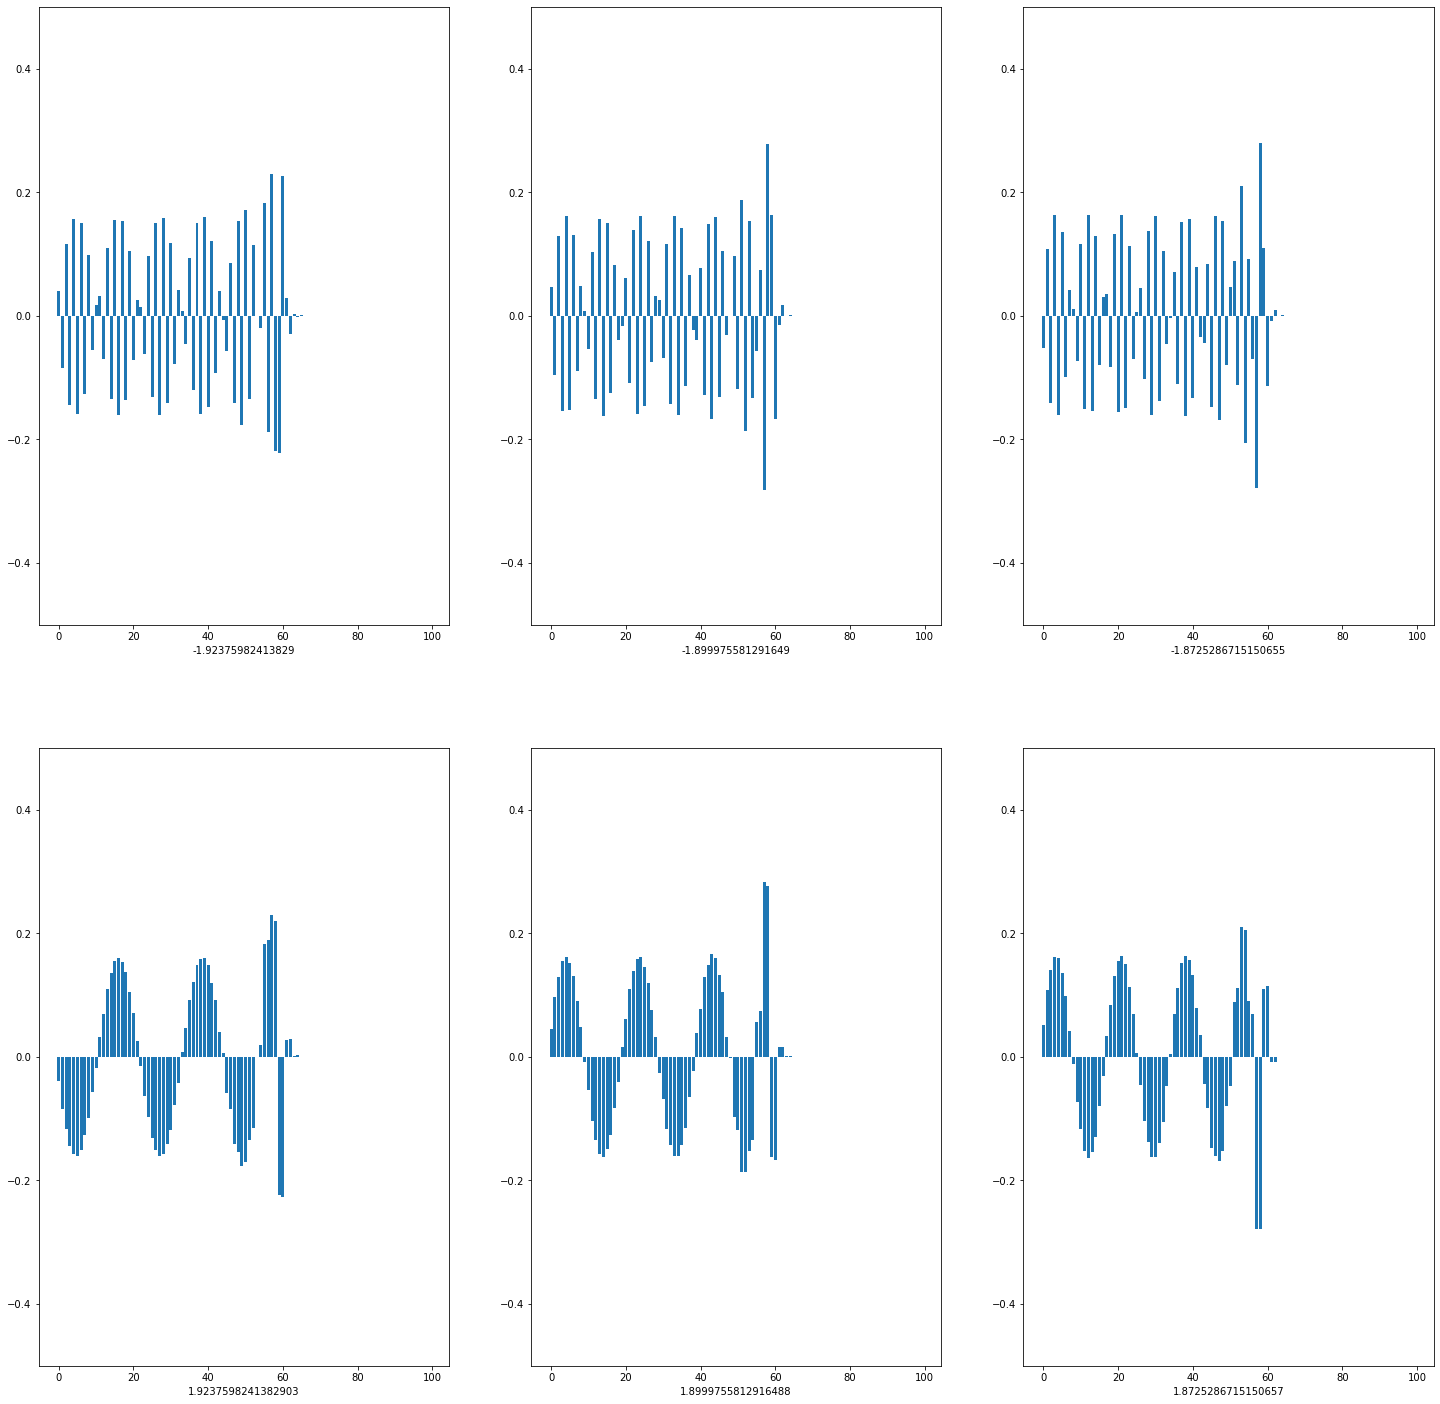

In [935]:
plot_perturbed_eigenvectors(H, 0.5)


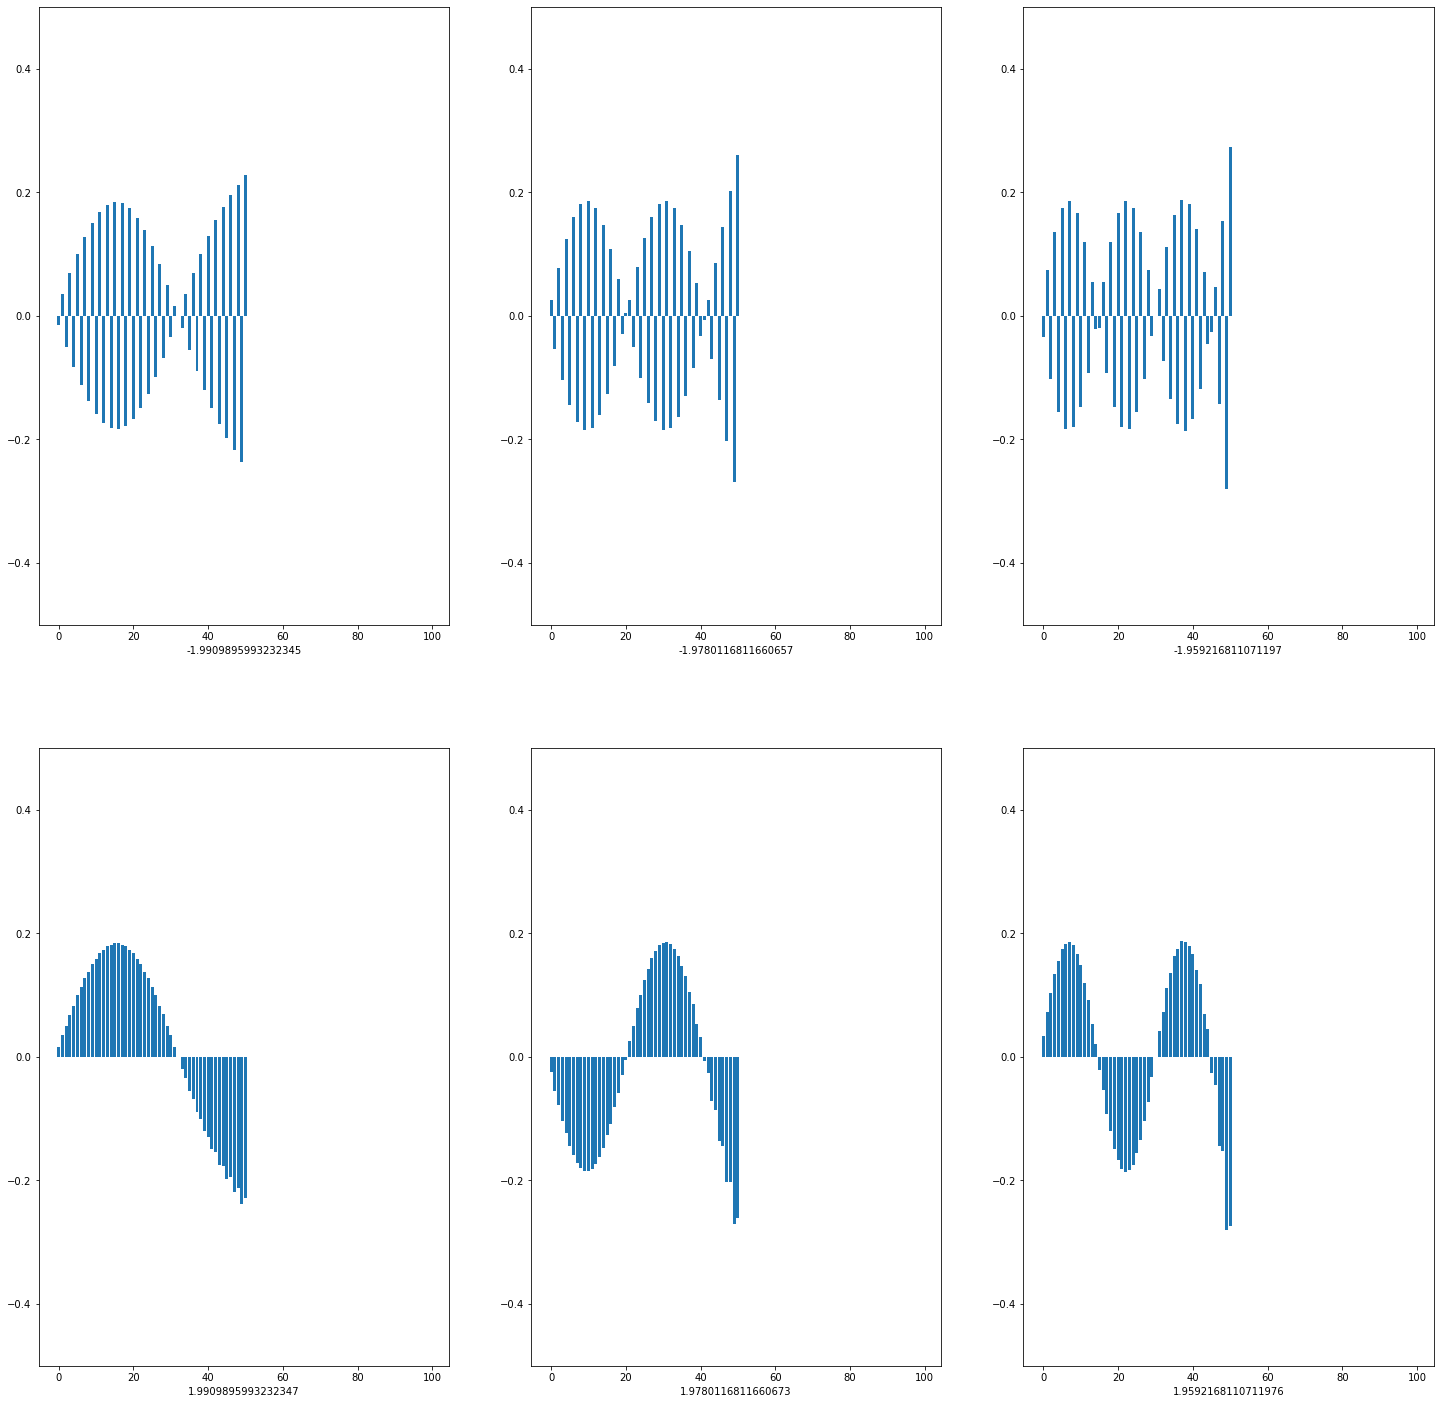

In [947]:
plot_perturbed_eigenvectors(H, 0.9)

In [641]:
s_eigs, s_vecs = H(0.5)
e_eigs, e_vecs = H(0.9)

s = 0
e = 0
for a in range(0,N):
    s+= right_charge(0, s_vecs[a], s_vecs[a])
    e += right_charge(0, e_vecs[a], e_vecs[a])
print(s, e)

j = -i/h [Q(a), H(t)]

<u(0)|j|u(0)> + <u(0)|j|delta_u(0)> + h.c

10.0 10.0


[ 0.3309479   0.15808082 -0.38315836 -0.28840692  0.36809654  0.36809654
 -0.28840692 -0.38315836  0.15808082  0.3309479 ] [ 6.96080776e-01  3.35004605e-02 -1.22630188e-01 -1.92811498e-01
  2.07182358e-02  6.25453136e-01 -2.03502613e-03 -2.65398684e-01
 -5.90283229e-05 -8.56500558e-03]


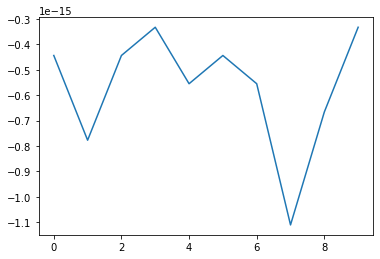

In [618]:
plt.plot(np.arange(0,N), explicit_polarization(toy_finite_hamiltonian(tanh_perturbation(N), N),N, max_e=0.9))

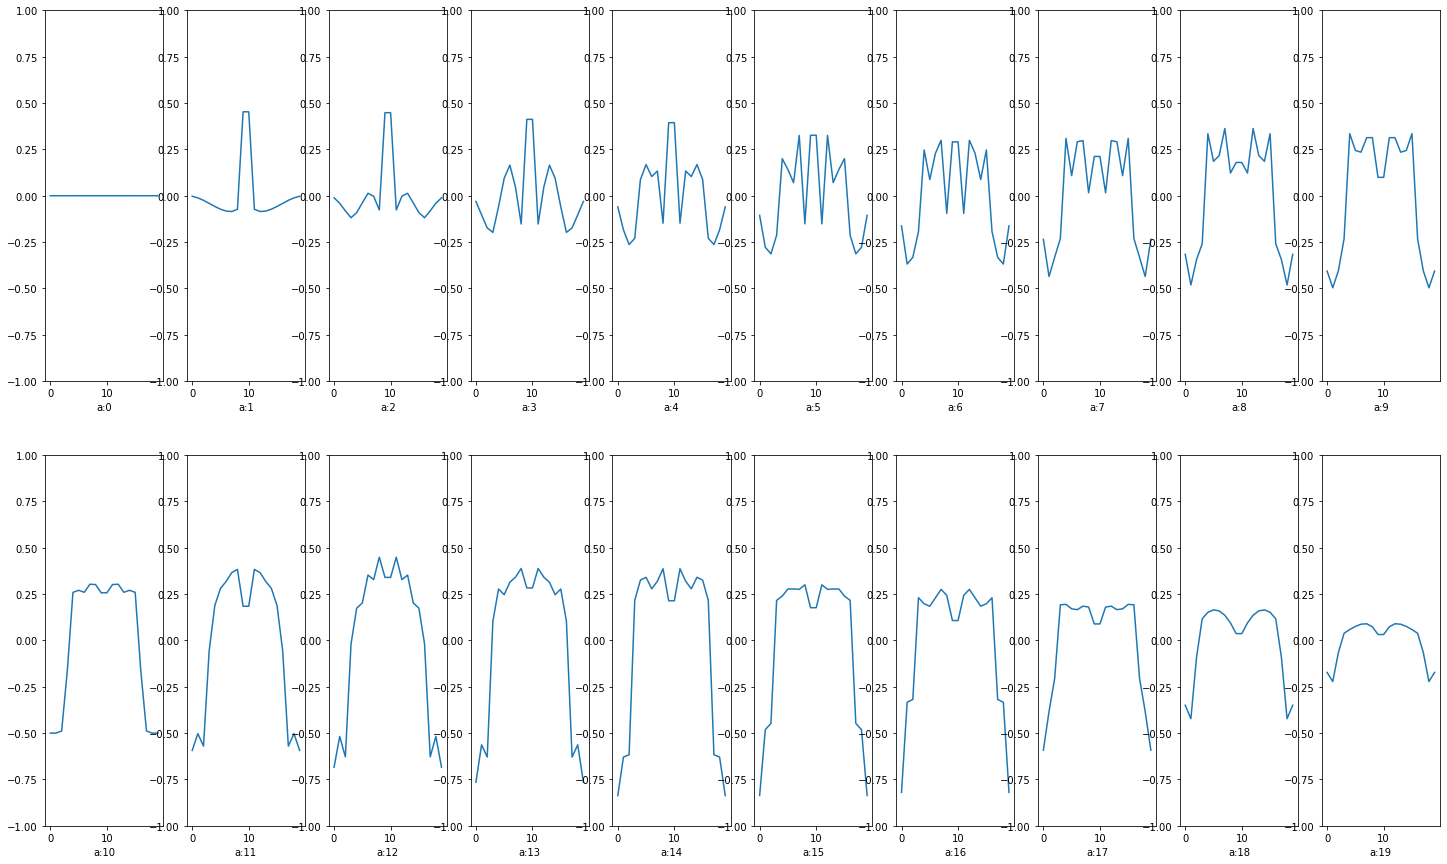

In [506]:
plot_perturbed_contribution(20,perturbation=tanh_perturbation(20),row_num=2)

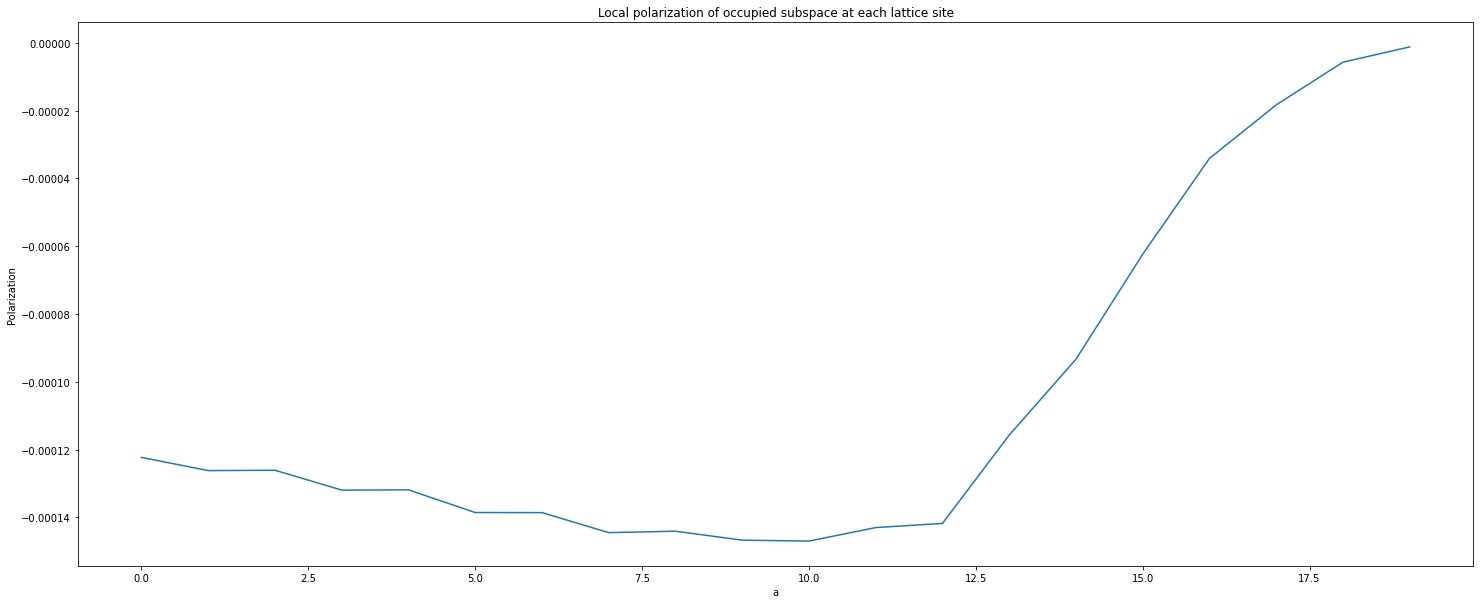

In [507]:
plot_perturbed_polarization(20, perturbation=tanh_perturbation(20))

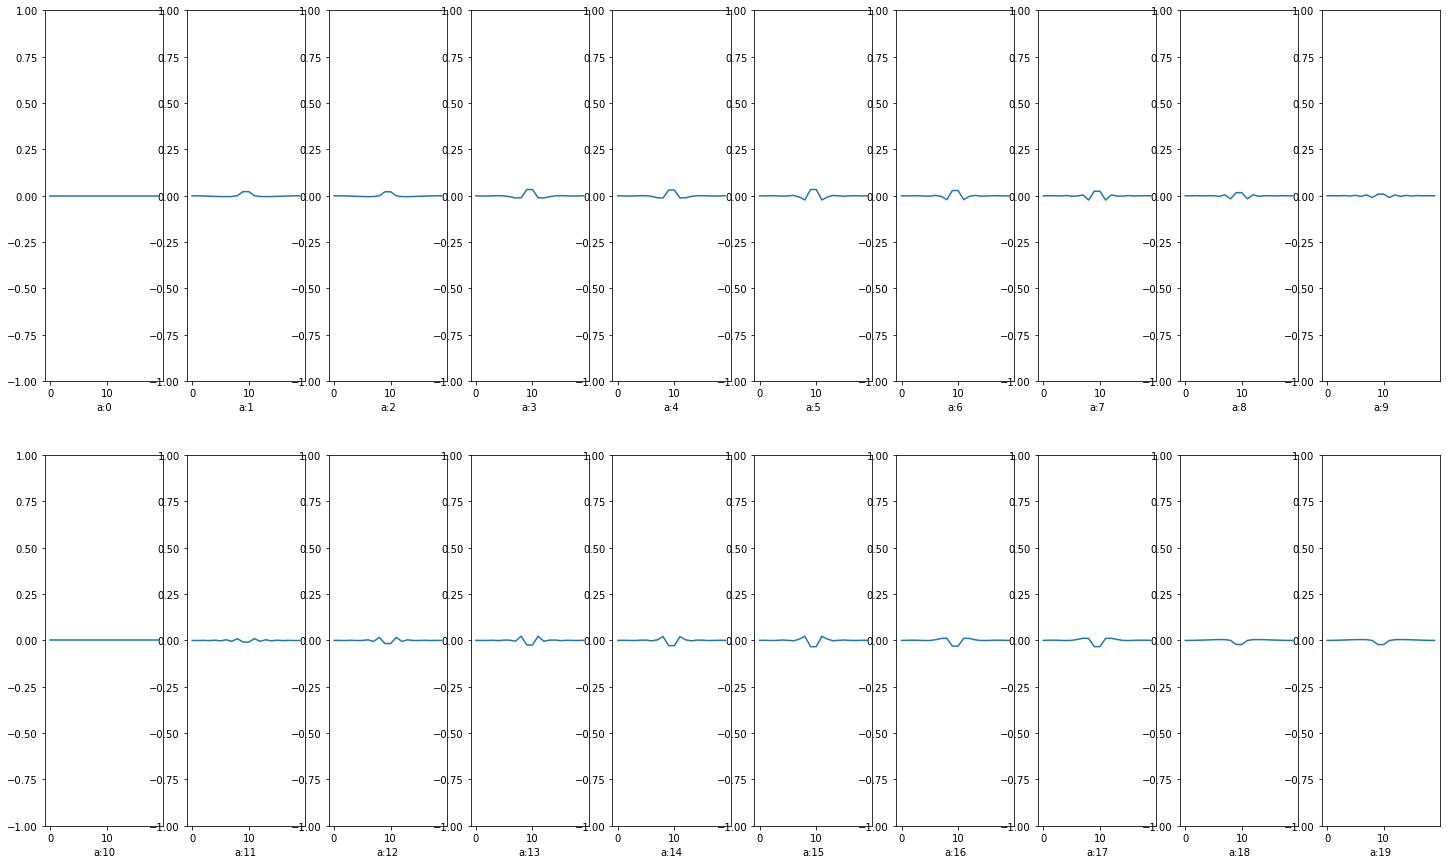

In [493]:
plot_perturbed_contribution(20)

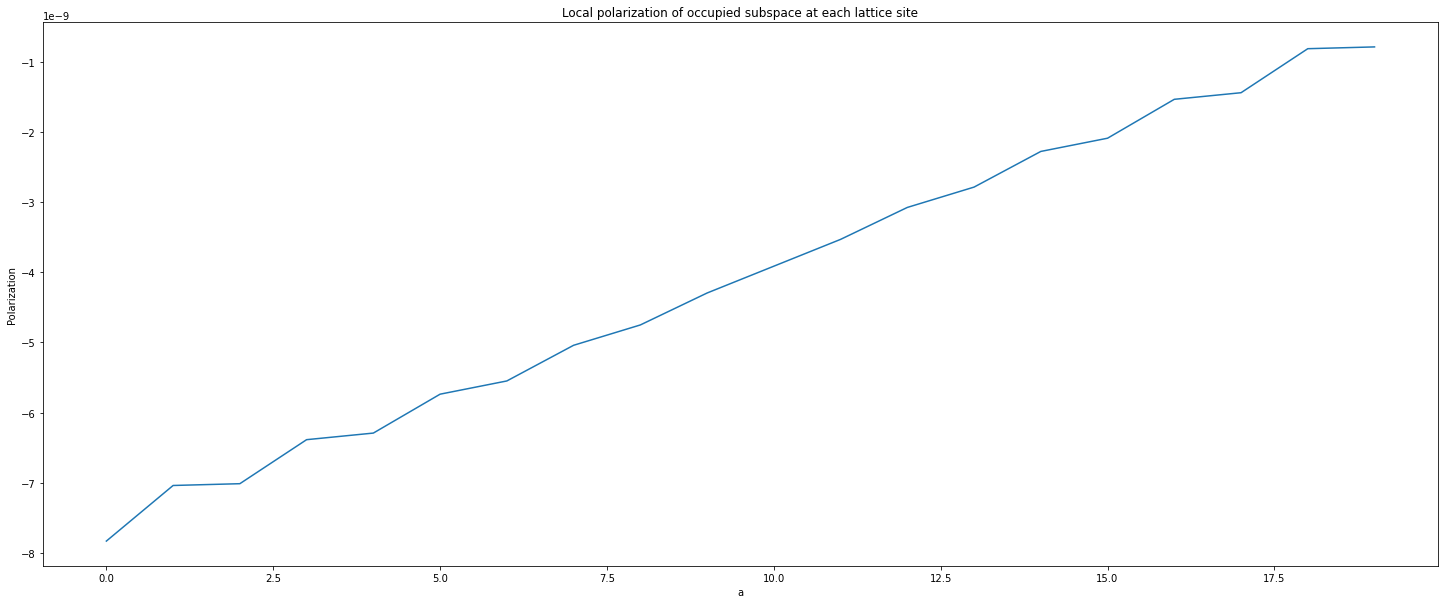

In [501]:
plot_perturbed_polarization(20)

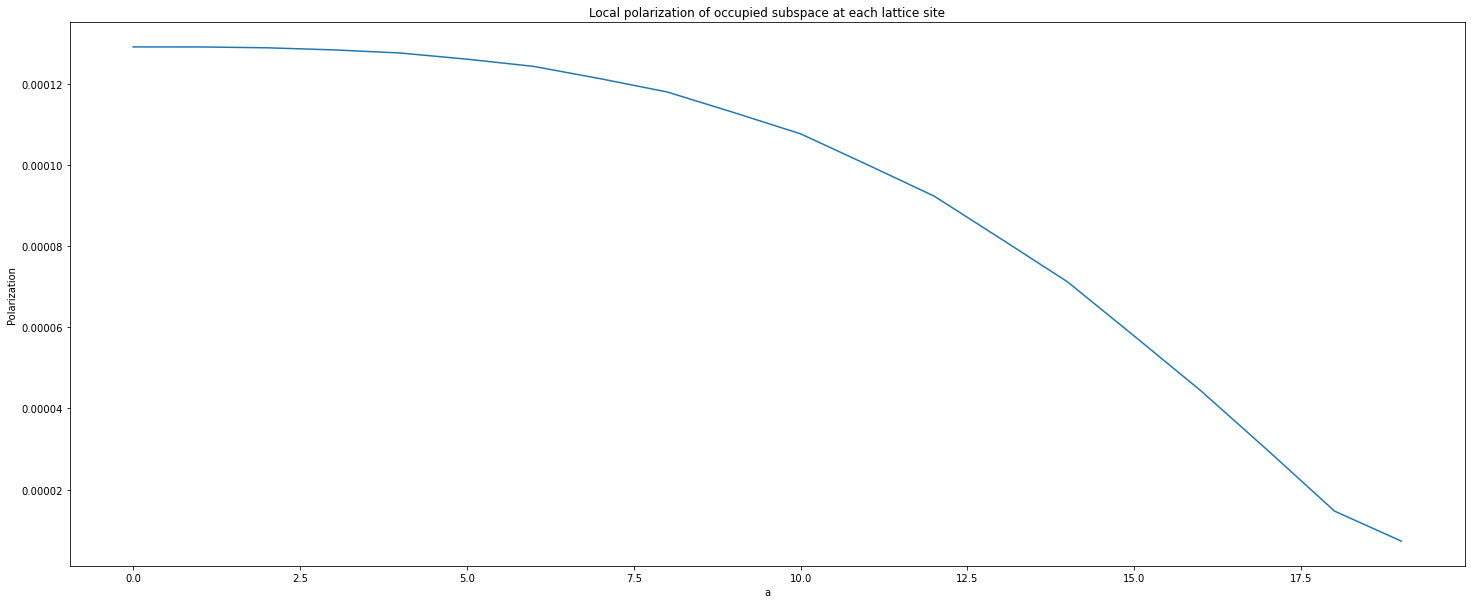

In [502]:
plot_perturbed_polarization(20, perturbation=linear_perturbation(20))

In [445]:
# Now if we wish to consider the change in polarization produced at a single lattice site a for different sizes of perturbations
def plot_lattice_polarization_change(N,a, max_e=0.9, steps=10, perturbation=None, row_num=2, col_num=10):
    if perturbation == None:
        perturbation = uniform_perturbation(N)
    
    plt.figure(figsize=(25,10))
    r = list(range(0,N))
    for i in range(0,steps):
        plt.subplot(row_num,col_num,i + 1)
        polarizations = np.sum(single_eig_current(toy_finite_hamiltonian(perturbation, N),a, timesteps=1000, max_e = max_e/steps * i), axis=0)
        plt.plot(r, polarizations)


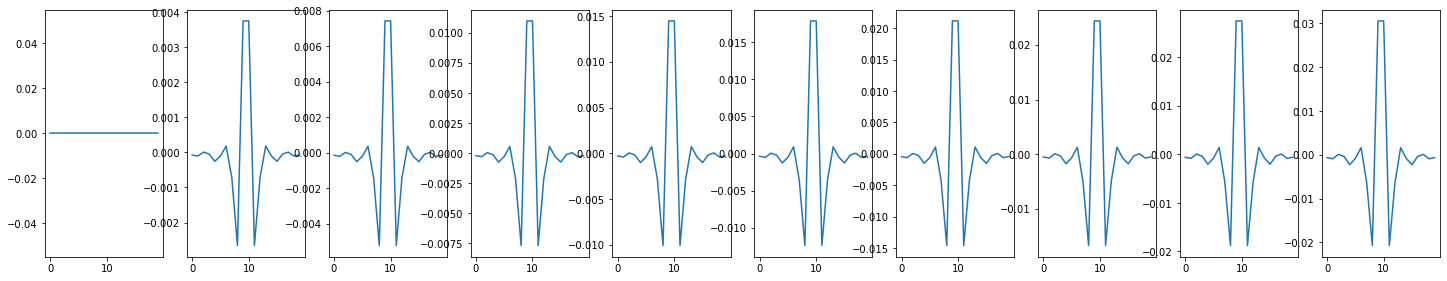

In [447]:
plot_lattice_polarization_change(30, 5, steps=10)

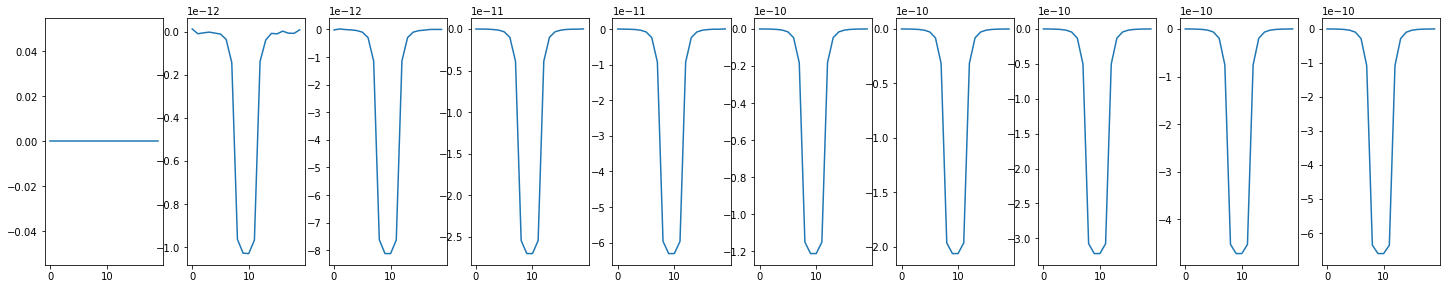

In [448]:
plot_lattice_polarization_change(30,10, steps=10)

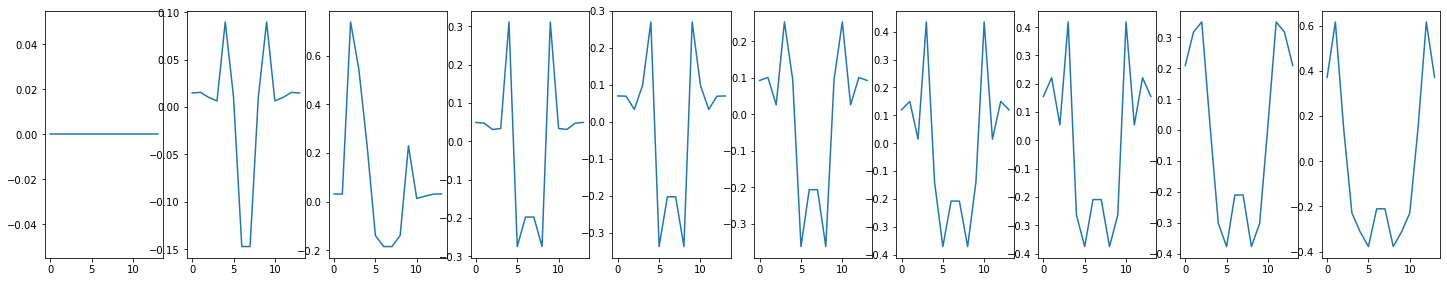

In [463]:
plot_lattice_polarization_change(14,10, steps=10, perturbation=tanh_perturbation(14))

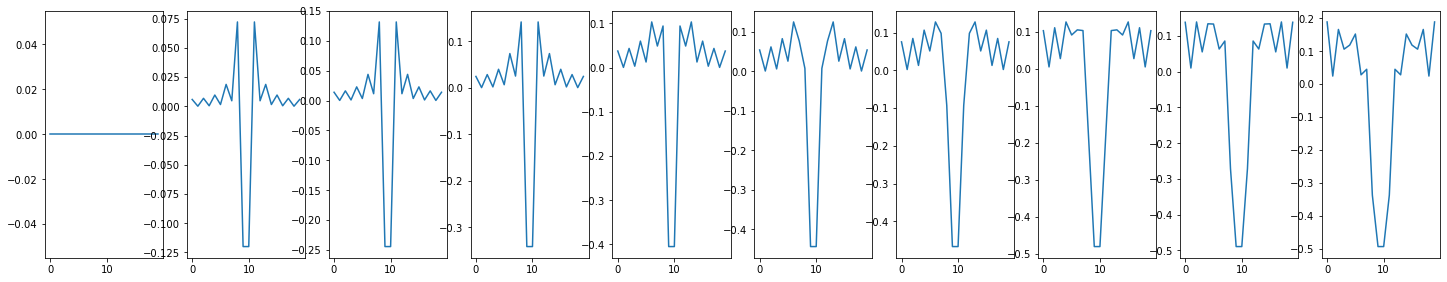

In [451]:
plot_lattice_polarization_change(20, 10, steps=10, perturbation=linear_perturbation(20))